# LINEAR APPROXIMATIONS TO REACTION NETWORKS

**TO DO**
1. Don't understand why NONLINEAR1 gives correct Jacobian with _MDL but not _RR

## Preliminaries

In [1]:
try:
    import controlSBML as ctl
except:
    !pip import controlSBML
    import controlSBML as ctl
try:
    from symmathSBML.symmath_sbml import SymmathSBML
except:
    !pip install symmathSBML
    from symmathSBML.symmath_sbml import SymmathSBML
    
import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

import os

## Constants

In [2]:
MODELS = ["LINEAR_MDL", "NONLINEAR1_MDL", "NONLINEAR2_MDL"]

# Antimony Models

Here we present 3 variations of a sequential pathway.
* LINEAR_MDL: The kinetics result in a linear system of ODEs
* NONLINEAR1_MDL: There is one quadratic rate law, affecting $S_2$, $S_3$
* NONLINEAR2_MDL: There are two quadratic rate laws, affecting $S_1$, $S_2$,$S_3$.

## LINEAR_MDL

In [3]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
LINEAR_MDL = """
//$S0 -> S1; $S0
S1 -> S2; k1*S1
S2 -> S3; k2*S2

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""

## NONLINEAR1_MDL

In [4]:
# Nonlinear model with one quadratic term
NONLINEAR1_MDL = """
$S0 -> S1; $S0
S1 -> S2; k2*S1*S1
S2 -> S3; k3*S2

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""

## NONLINEAR2_MDL

In [5]:
# Nonlinear model with two quadratic term
NONLINEAR2_MDL = """
$S0 -> S1; $S0
S1 -> S2; k2*S1*S1
S2 -> S3; k3*S2*S1

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""

## Model Plots

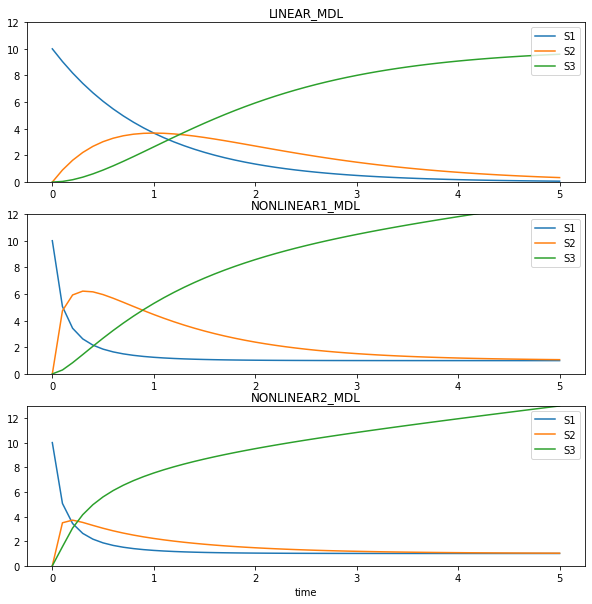

In [6]:
# Plot the three models
_, axes = plt.subplots(3, 1, figsize=(15, 10))
for idx, mdl in enumerate(MODELS):
    ctlsb = ctl.ControlSBML(eval(mdl))
    ax = axes[idx]
    if idx == len(axes) - 1:
        is_plot = True
    else:
        is_plot = False
    ctlsb.plotTrueModel(ax=ax, is_plot=is_plot, title=mdl)
    if idx < len(axes) - 1:
        ax.set_xlabel("")
    ax.set_ylim([0, 12])
    

# Helpers

# Accuracy of Linear Model: Sequential Pathway

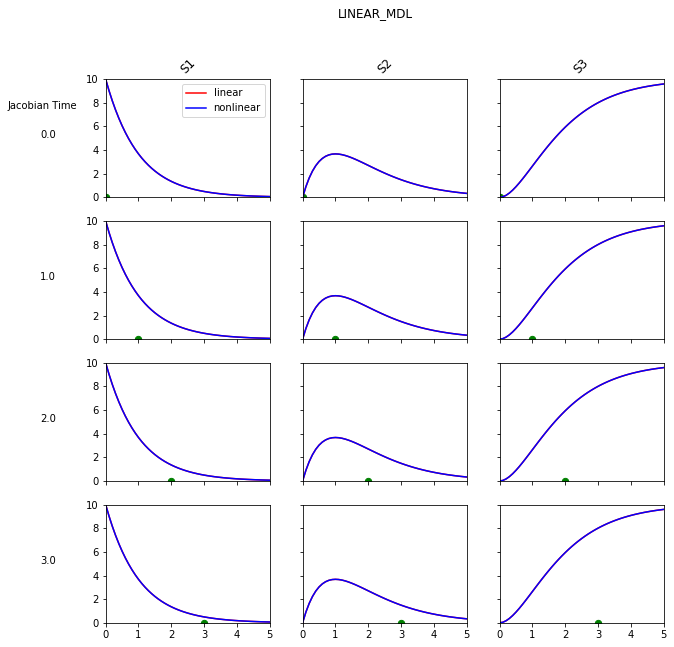

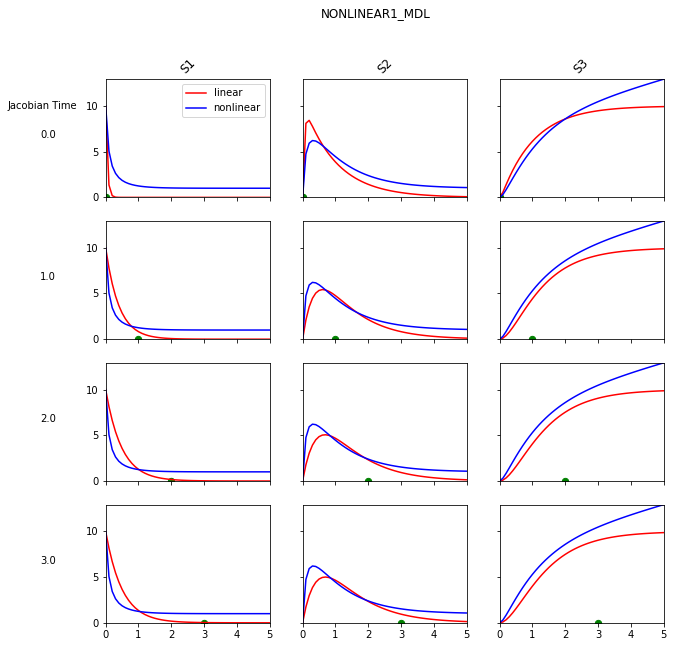

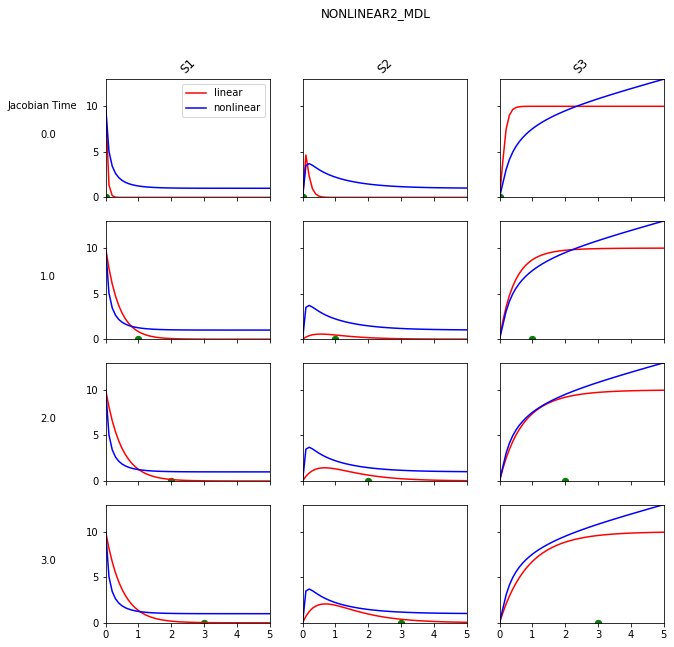

In [34]:
timepoints = range(5)
for name in MODELS:
    ctlsb = ctl.ControlSBML(eval(name))
    ctlsb.plotAccuracy(timepoints=[0, 1, 2,3], suptitle=name, is_plot=True, step_val=0)

In [9]:
try:
    symmath = SymmathSBML(NONLINEAR2_MDL)
    symmath.jacobian_df
except:
    pass

**Notes**
1. For S0, the time at which the Jacobian is calculated doesn't matter since $\frac {\partial S_0}{S_n}$ is a constant (0).
1. $S_1$, $S_2$, $S_3$ have non-constant partial derivatives and so their Jacobian will change with the timepoint.

In [10]:
for mdl in MODELS:
    print(mdl)
    symmath = SymmathSBML(eval(mdl))
    jacobian = symmath.getJacobian()
    print(jacobian)

LINEAR_MDL
                   S1                 S2 S3
S1  -1.00000000000000                  0  0
S2   1.00000000000000  -1.00000000000000  0
S3                  0   1.00000000000000  0
NONLINEAR1_MDL
                   S0       S1                 S2 S3
S0  -1.00000000000000        0                  0  0
S1   1.00000000000000  -2.0*S1                  0  0
S2                  0   2.0*S1  -1.00000000000000  0
S3                  0        0   1.00000000000000  0
NONLINEAR2_MDL
                   S0               S1       S2 S3
S0  -1.00000000000000                0        0  0
S1   1.00000000000000          -2.0*S1        0  0
S2                  0  2.0*S1 - 1.0*S2  -1.0*S1  0
S3                  0           1.0*S2   1.0*S1  0


# Choosing Inputs to Force System into A Desired Stat

In [11]:
## Theory

Consider the system $\dot{\bf x}(t) = {\bf A} {\bf x}(t) + {\bf B} {\bf u} (t)$.
If the system is stable, can we choose ${\bf u}(t)$ so that it converges to ${\bf x}_f$.
That is, $lim_{t \rightarrow \infty} {\bf x}(t) = {\bf x}_f$.
1. Consider steady state. That is, ${\bf 0} = {\bf A} {\bf x}_f + {\bf B} {\bf u}$. We want to solve for ${\bf u}$.
1. Argue that ${\bf B}$ has full column rank and so ${\bf B}^T {\bf B}$ is non-singular.
1. So, ${\bf u} = -\left( {\bf B}^T {\bf B} \right) ^{-1} {\bf B}^T {\bf A} {\bf x}_f$.
1. Note that this solution exists only if $\left( {\bf B}^T {\bf B} \right) ^{-1} {\bf B}^T {\bf A}$
has row rank $p$.

Dimensional analysis of the solution.
* $dim ({\bf A}) = n \times n$
* $dim({\bf B}) = n \times p$, where $p \leq n$.
* $dim ({\bf x}_f) = n \times 1$

* $dim({\bf B}^T {\bf B}) = p \times p$
* $dim ( \left[ {\bf B}^T {\bf B} \right]^{-1} {\bf B}^T) = p \times n$
* $dim \left( \left[ {\bf B}^T {\bf B} \right]^{-1} {\bf B}^T) {\bf A} {\bf x}_f \right) = p \times 1$

Why condition (4) is important.
* Consider ${\bf B} = [1, 1, 1]^T$.
* ${\bf A}$ as defined below.
* Then $\left[ {\bf B}^T {\bf B} \right]^{-1} {\bf B}^T {\bf A} = [0, 0, 0]^T$

## Calculations

In [12]:
ctlsb = ctl.ControlSBML(LINEAR_MDL)

In [13]:
B_mat = np.array([1, 1, 2])
B_mat = np.reshape(B_mat, (3,1))
sys = ctlsb.makeMIMOLinearSystem(B_mat=B_mat)
sys

StateSpace(array([[-1.,  0.,  0.],
       [ 1., -1.,  0.],
       [ 0.,  1.,  0.]]), array([[1.],
       [1.],
       [2.]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[0.],
       [0.],
       [0.]]))

In [14]:
np.transpose(sys.A)

array([[-1.,  1.,  0.],
       [ 0., -1.,  1.],
       [ 0.,  0.,  0.]])

In [15]:
X0 = np.array([10, 0, 0])
X0 = np.reshape(X0, (len(X0),1))
T = [1, 2, 3, 4, 5]
result = control.forced_response(sys, T=T, U=np.repeat(1, len(T)), X0=X0)
[result.time, result.x]

[array([1, 2, 3, 4, 5]),
 array([[10.        ,  4.31091497,  2.21801755,  1.44808362,  1.16484075],
        [ 0.        ,  4.57515609,  4.16536453,  3.24467671,  2.62273172],
        [ 0.        ,  5.11392894, 11.61661792, 17.30723968, 22.21242753]])]

In [16]:
result = control.forced_response(sys, T=T,  U=np.repeat(0, len(T)), X0=X0)
[result.time, result.x]

[array([1, 2, 3, 4, 5]),
 array([[10.        ,  3.67879441,  1.35335283,  0.49787068,  0.18315639],
        [ 0.        ,  3.67879441,  2.70670566,  1.49361205,  0.73262556],
        [ 0.        ,  2.64241118,  5.9399415 ,  8.00851727,  9.08421806]])]

In [17]:
# Check controlability
np.concatenate([sys.B, np.matmul(sys.A, sys.B)], axis=1)

array([[ 1., -1.],
       [ 1.,  0.],
       [ 2.,  1.]])

In [18]:
# Determine if the system is controlable by checking if the determinant of the controlability matrix is non-zero.
np.linalg.det(control.ctrb(sys.A, sys.B))

3.999999999999999

Find an input that creates an arbitray state, say the state [1, 2, 3]

In [19]:
Xf = np.array([1, 2, 3])
Xf = np.reshape(Xf, (3, 1))
adj_Xf = Xf - X0
U = np.matmul(np.linalg.inv(control.ctrb(sys.A, sys.B)), adj_Xf)
U

array([[-1.],
       [ 5.],
       [-3.]])

In [20]:
T = [0, 1, 2]
#U = np.reshape(U, len(T))
result = control.forced_response(sys, T=T,  U=np.repeat(-1.667, len(T)), X0=X0)
[result.time, result.x]

[array([0, 1, 2]),
 array([[10.        ,  2.62504944, -0.08804325],
        [ 0.        ,  2.1845595 ,  0.27512133],
        [ 0.        , -1.47760894, -3.52307808]])]

How do I find the forced inputs that create a desired final state?
1. Consider steady state. That is, ${\bf 0} = {\bf A} {\bf x}_f + {\bf B} {\bf u}$. We want to solve for {\bf u}.
1. Argue that ${\bf B}$ has full column rank and so ${\bf B}^T {\bf B}$ is non-singular.
1. So, ${\bf u} = \left( {\bf B}^T {\bf B} \right) ^{-1} {\bf B}^T {\bf A} {\bf x}_f$.

In [21]:
Xf = np.array([2, 5, 3])
Xf = np.reshape(Xf, (3, 1))
1/3*np.matmul(np.transpose(sys.B), -np.matmul(sys.A, Xf))

array([[-1.66666667]])

Note that ${\bf 1}^T  {\bf A}{\bf x}_f  = 0$ because of conservation of mass; all mass in the first step becomes mass at the last step.
**This is a good homework problem.**

In [22]:
-np.matmul(sys.A, Xf)

array([[ 2.],
       [ 3.],
       [-5.]])

# Wolf Model

In [23]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml")

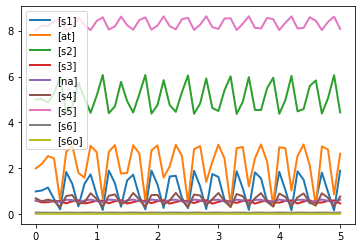

In [24]:
rr.plot(rr.simulate())

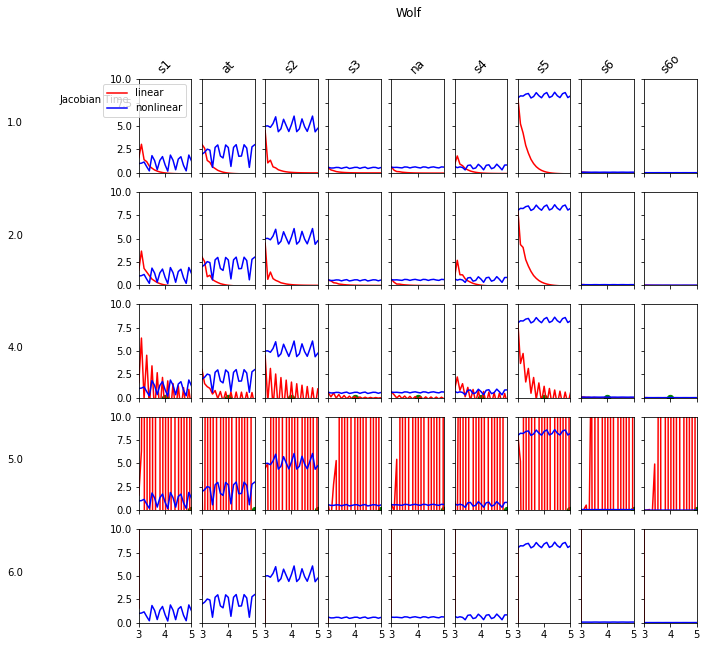

In [31]:
ctlsb = ctl.ControlSBML(rr)
ctlsb.plotAccuracy(rr, [1, 2, 4, 5, 6], suptitle="Wolf", start_time=3, end_time=5, ylim=[0, 10])

# mTOR (BioModels 823)

In [26]:
ctlsb_823 = ctl.ControlSBML(ctl.BIOMODELS_DCT[823])

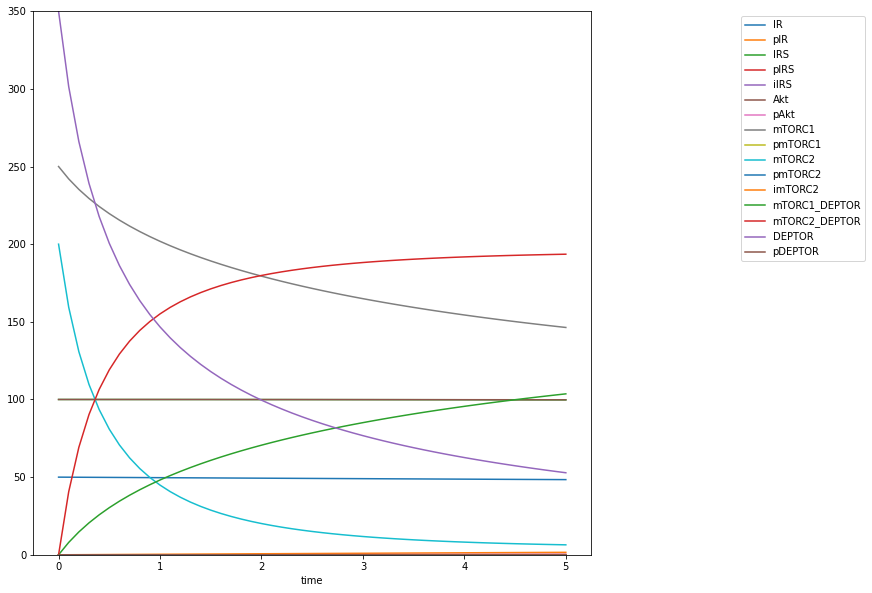

In [27]:
ctlsb_823.plotTrueModel(legend_crd=(1.5, 1))

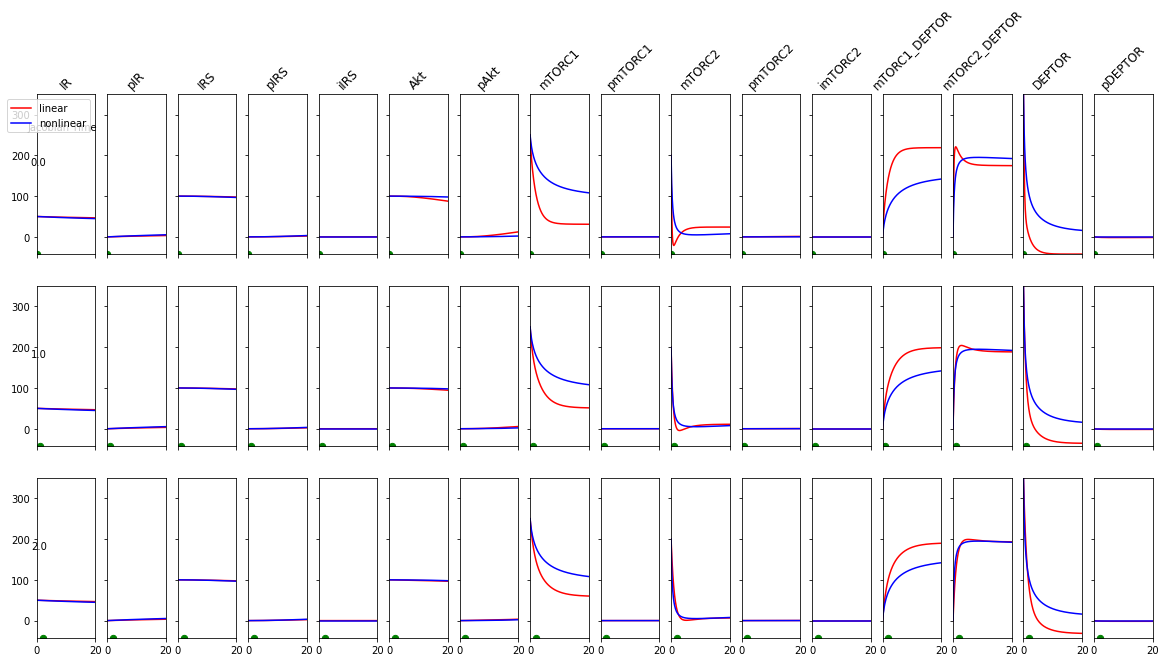

In [28]:
ctlsb_823.plotAccuracy(timepoints=[0, 1, 2], figsize=(20, 10), end_time=20)

## Forced Inputs